In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [5]:
nba_series = pd.read_csv("TEAM_MATCHUP_DATA_FINAL.csv") # replace with your path
nba_series['SEASON'] = nba_series['SEASON'].astype(int)


# Trained on data from 1997-1999 and tested on 2000 data
train_data_gen = nba_series[nba_series['SEASON'] < 2005]
test_data_gen = nba_series[nba_series['SEASON'] == 2005]

# Separate out the columns to keep for comparison
columns_to_keep = ['SERIES_ID', 'SEASON', 'TEAM_1', 'TEAM_2', 'SERIES_WINNER']
# Save the original data with the columns to keep
train_data_preserved = train_data_gen[columns_to_keep]
test_data_preserved = test_data_gen[columns_to_keep]

# Drop columns before training the model
nba_series = nba_series.drop(columns = ['SERIES_ID', 'SEASON', 'SEASON_ID', 'TEAM_1_ID', 'TEAM_2_ID'])
train_data_gen = train_data_gen.drop(columns = ['SERIES_ID', 'SEASON', 'SEASON_ID', 'TEAM_1_ID', 'TEAM_2_ID'])
test_data_gen = test_data_gen.drop(columns = ['SERIES_ID', 'SEASON', 'SEASON_ID', 'TEAM_1_ID', 'TEAM_2_ID'])

# Set up the target variable as TEAM_1_W and drop TEAM_1, TEAM_2, and SERIES_WINNER variables
nba_series['TEAM_1_W'] = (nba_series['SERIES_WINNER'] == nba_series['TEAM_1']).astype(int)
nba_series = nba_series.drop(columns = ['TEAM_1', 'TEAM_2', 'SERIES_WINNER'])

train_data_gen['TEAM_1_W'] = (train_data_gen['SERIES_WINNER'] == train_data_gen['TEAM_1']).astype(int)
train_data_gen = train_data_gen.drop(columns = ['TEAM_1', 'TEAM_2', 'SERIES_WINNER'])

test_data_gen['TEAM_1_W'] = (test_data_gen['SERIES_WINNER'] == test_data_gen['TEAM_1']).astype(int)
test_data_gen = test_data_gen.drop(columns = ['TEAM_1', 'TEAM_2', 'SERIES_WINNER'])


# Load the dataset (nba_series) and separate features (X) and target (y)
X = nba_series.drop(columns=['TEAM_1_W'])
y = nba_series['TEAM_1_W']

In [6]:
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Standardize the features
scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)

# Compute class weights to handle imbalance
class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=y_resampled)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Build the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_dim=X_train.shape[1]),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# Set up early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),
                    class_weight=class_weight_dict, callbacks=[early_stopping])


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5862 - loss: 0.7043 - val_accuracy: 0.6296 - val_loss: 0.6684
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6356 - loss: 0.6119 - val_accuracy: 0.6931 - val_loss: 0.6158
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7668 - loss: 0.5027 - val_accuracy: 0.7302 - val_loss: 0.5378
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7719 - loss: 0.4621 - val_accuracy: 0.7196 - val_loss: 0.5749
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8238 - loss: 0.3847 - val_accuracy: 0.7831 - val_loss: 0.5102
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8630 - loss: 0.3236 - val_accuracy: 0.7407 - val_loss: 0.5555
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8971 - loss: 0.2788 - val_accuracy: 0.7937 - val_loss: 0.5275
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9011 - loss: 0.2937 - val_accuracy: 0.7937 - val_loss: 0.

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Model Accuracy: 82.01%

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.88      0.83        96
           1       0.86      0.76      0.81        93

    accuracy                           0.82       189
   macro avg       0.82      0.82      0.82       189
weighted avg       0.82      0.82      0.82       189



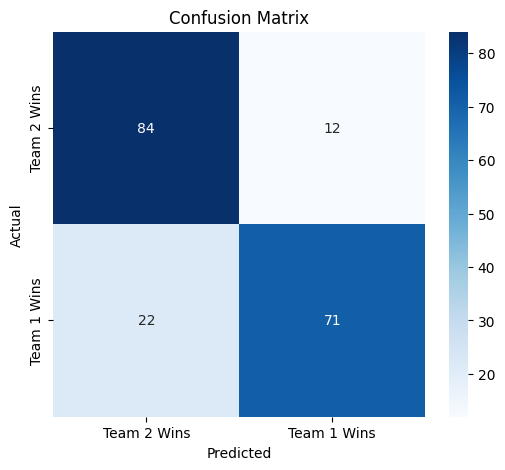

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


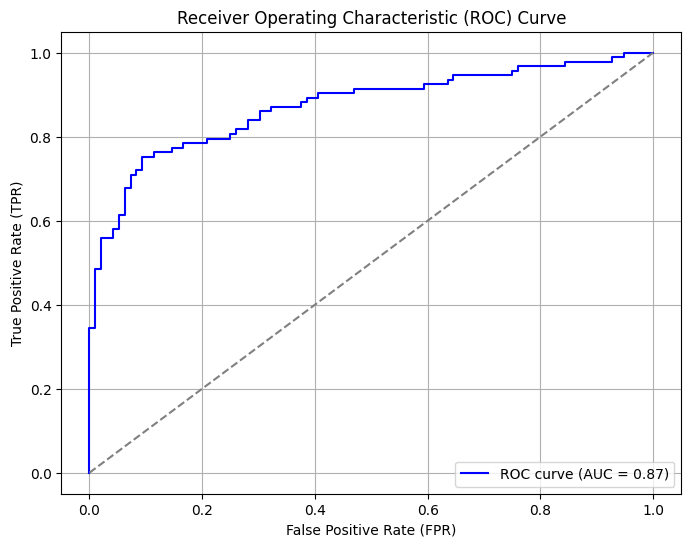

In [7]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Evaluate the model
print(f"Model Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Team 2 Wins', 'Team 1 Wins'],
            yticklabels=['Team 2 Wins', 'Team 1 Wins'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Get the predicted probabilities for the positive class (Team 1 Wins)
y_prob = model.predict(X_test)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (no discrimination)
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8754 - loss: 0.2755 - val_accuracy: 0.8667 - val_loss: 0.2505
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8683 - loss: 0.2473 - val_accuracy: 0.9333 - val_loss: 0.1190
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9069 - loss: 0.2496 - val_accuracy: 1.0000 - val_loss: 0.0758
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9235 - loss: 0.2066 - val_accuracy: 0.8667 - val_loss: 0.2149
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9237 - loss: 0.1868 - val_accuracy: 0.8000 - val_loss: 0.3260
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9265 - loss: 0.2087 - val_accuracy: 0.9333 - val_loss: 0.1329
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9267 - loss: 0.2140 - val_accuracy: 0.9333 - val_loss: 0.1900
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9508 - loss: 0.1467 - val_accuracy: 0.8667 - val_loss: 0.3346


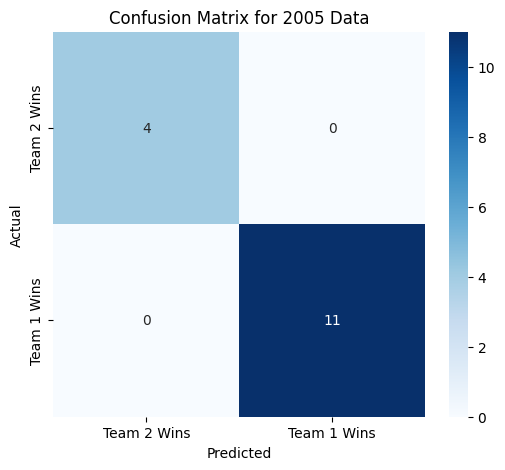

,SERIES_ID,SEASON,TEAM_1,TEAM_2,SERIES_WINNER,PRED_WINNER
120,2005_BOS_IND,2005,Boston Celtics,Indiana Pacers,Indiana Pacers,0
121,2005_CHI_WAS,2005,Chicago Bulls,Washington Wizards,Washington Wizards,0
122,2005_DAL_HOU,2005,Dallas Mavericks,Houston Rockets,Dallas Mavericks,1
123,2005_DAL_PHX,2005,Phoenix Suns,Dallas Mavericks,Phoenix Suns,1
124,2005_DEN_SAS,2005,San Antonio Spurs,Denver Nuggets,San Antonio Spurs,1
125,2005_DET_IND,2005,Detroit Pistons,Indiana Pacers,Detroit Pistons,1
126,2005_DET_MIA,2005,Miami Heat,Detroit Pistons,Detroit Pistons,0
127,2005_DET_PHI,2005,Detroit Pistons,Philadelphia 76ers,Detroit Pistons,1
128,2005_DET_SAS,2005,San Antonio Spurs,Detroit Pistons,San Antonio Spurs,1
129,2005_MEM_PHX,2005,Phoenix Suns,Memphis Grizzlies,Phoenix Suns,1


In [8]:
X_train_gen = train_data_gen.drop(columns=['TEAM_1_W'])
y_train_gen = train_data_gen['TEAM_1_W']
X_test_gen = test_data_gen.drop(columns=['TEAM_1_W'])
y_test_gen = test_data_gen['TEAM_1_W']

# Standardize the features for 2024 data
X_train_gen = scaler.transform(X_train_gen)
X_test_gen = scaler.transform(X_test_gen)

# Train the model
model.fit(X_train_gen, y_train_gen, epochs=50, batch_size=32, validation_data=(X_test_gen, y_test_gen),
          class_weight=class_weight_dict, callbacks=[early_stopping])

# Make predictions on the 2016 test data
y_pred_gen = (model.predict(X_test_gen) > 0.5).astype("int32")

# Evaluate the model on 2024 data
print(f"Accuracy on 2005 data: {accuracy_score(y_test_gen, y_pred_gen) * 100:.2f}%")
print("\nClassification Report for 2005 data:")
print(classification_report(y_test_gen, y_pred_gen))

# Confusion matrix for 2024 data
cm_24 = confusion_matrix(y_test_gen, y_pred_gen)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_24, annot=True, fmt='d', cmap='Blues', xticklabels=['Team 2 Wins', 'Team 1 Wins'],
            yticklabels=['Team 2 Wins', 'Team 1 Wins'])
plt.title('Confusion Matrix for 2005 Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

test_data_preserved['PRED_WINNER'] = y_pred_gen
test_data_preserved

In [14]:
param_grid = {
    'model__optimizer': ['adam', 'sgd', 'rmsprop'],  # Different optimizers
    'model__dropout_rate': [0.2, 0.3, 0.4],  # Dropout rates
    'model__neurons_layer1': [128, 256, 512],  # Number of neurons in the first hidden layer
    'model__neurons_layer2': [64, 128, 256],  # Number of neurons in the second hidden layer
    'model__batch_size': [16, 32, 64],  # Batch sizes
    'model__epochs': [30, 50, 70],  # Number of epochs
    'model__learning_rate': [0.001, 0.0005, 0.0001]  # Learning rates
}


In [12]:
!pip install keras-tuner
model = KerasClassifier(model=create_model, verbose=0)  # Use `model=` instead of `build_fn=`


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.6 MB/s eta 0:00:00


NameError: name 'KerasClassifier' is not defined

In [13]:
import keras_tuner as kt

In [14]:
def model_builder(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(units=hp.Int('units', min_value=32, max_value=512, step=32),
                                    activation='relu', input_dim=X_train.shape[1]))
    model.add(tf.keras.layers.Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    # Define the optimizer with tunable learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [15]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
tuner.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

Trial 30 Complete [00h 00m 04s]
val_accuracy: 0.7301587462425232

Best val_accuracy So Far: 0.8624338507652283
Total elapsed time: 00h 01m 49s


In [19]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)


In [20]:
history = best_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),
                         class_weight=class_weight_dict, callbacks=[early_stopping])

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5639 - loss: 0.7163 - val_accuracy: 0.7143 - val_loss: 0.5651
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7757 - loss: 0.4816 - val_accuracy: 0.7566 - val_loss: 0.5314
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8687 - loss: 0.3768 - val_accuracy: 0.7831 - val_loss: 0.4913
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8781 - loss: 0.3322 - val_accuracy: 0.7619 - val_loss: 0.4896
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8873 - loss: 0.3023 - val_accuracy: 0.8042 - val_loss: 0.4601
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9333 - loss: 0.2494 - val_accuracy: 0.8095 - val_loss: 0.4526
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9596 - loss: 0.2153 - val_accuracy: 0.8148 - val_loss: 0.4451
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9522 - loss: 0.2056 - val_accuracy: 0.8307 - val_l

In [21]:
y_pred = best_model.predict(X_test)
y_pred = (y_pred > 0.5).astype("int32")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [23]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 85.19%


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9381 - loss: 0.1469 - val_accuracy: 1.0000 - val_loss: 0.0761
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9685 - loss: 0.1000 - val_accuracy: 0.9333 - val_loss: 0.1619
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9654 - loss: 0.0932 - val_accuracy: 0.9333 - val_loss: 0.1334
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9798 - loss: 0.0750 - val_accuracy: 0.9333 - val_loss: 0.1471
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 1.0000 - loss: 0.0707 - val_accuracy: 0.8667 - val_loss: 0.2321
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9915 - loss: 0.0568 - val_accuracy: 0.8667 - val_loss: 0.2804
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Accuracy on 2005 data: 100.00%

Classification Report for 2005 data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00 

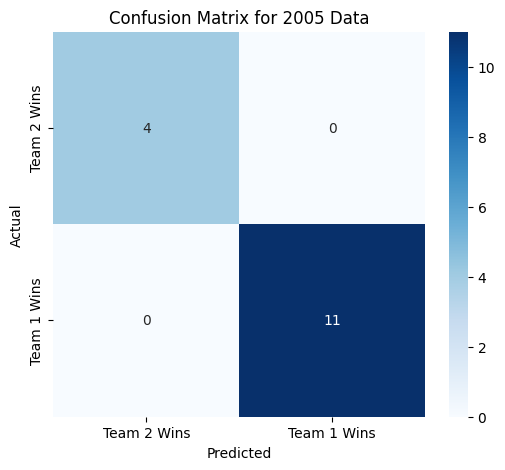

,SERIES_ID,SEASON,TEAM_1,TEAM_2,SERIES_WINNER,PRED_WINNER
120,2005_BOS_IND,2005,Boston Celtics,Indiana Pacers,Indiana Pacers,0
121,2005_CHI_WAS,2005,Chicago Bulls,Washington Wizards,Washington Wizards,0
122,2005_DAL_HOU,2005,Dallas Mavericks,Houston Rockets,Dallas Mavericks,1
123,2005_DAL_PHX,2005,Phoenix Suns,Dallas Mavericks,Phoenix Suns,1
124,2005_DEN_SAS,2005,San Antonio Spurs,Denver Nuggets,San Antonio Spurs,1
125,2005_DET_IND,2005,Detroit Pistons,Indiana Pacers,Detroit Pistons,1
126,2005_DET_MIA,2005,Miami Heat,Detroit Pistons,Detroit Pistons,0
127,2005_DET_PHI,2005,Detroit Pistons,Philadelphia 76ers,Detroit Pistons,1
128,2005_DET_SAS,2005,San Antonio Spurs,Detroit Pistons,San Antonio Spurs,1
129,2005_MEM_PHX,2005,Phoenix Suns,Memphis Grizzlies,Phoenix Suns,1


In [24]:
X_train_gen = train_data_gen.drop(columns=['TEAM_1_W'])
y_train_gen = train_data_gen['TEAM_1_W']
X_test_gen = test_data_gen.drop(columns=['TEAM_1_W'])
y_test_gen = test_data_gen['TEAM_1_W']

# Standardize the features for 2024 data
X_train_gen = scaler.transform(X_train_gen)
X_test_gen = scaler.transform(X_test_gen)

# Train the model
best_model.fit(X_train_gen, y_train_gen, epochs=50, batch_size=32, validation_data=(X_test_gen, y_test_gen),
          class_weight=class_weight_dict, callbacks=[early_stopping])

# Make predictions on the 2016 test data
y_pred_gen = (model.predict(X_test_gen) > 0.5).astype("int32")

# Evaluate the model on 2024 data
print(f"Accuracy on 2005 data: {accuracy_score(y_test_gen, y_pred_gen) * 100:.2f}%")
print("\nClassification Report for 2005 data:")
print(classification_report(y_test_gen, y_pred_gen))

# Confusion matrix for 2024 data
cm_24 = confusion_matrix(y_test_gen, y_pred_gen)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_24, annot=True, fmt='d', cmap='Blues', xticklabels=['Team 2 Wins', 'Team 1 Wins'],
            yticklabels=['Team 2 Wins', 'Team 1 Wins'])
plt.title('Confusion Matrix for 2005 Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

test_data_preserved['PRED_WINNER'] = y_pred_gen
test_data_preserved

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Model Accuracy: 85.71%

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86        96
           1       0.88      0.83      0.85        93

    accuracy                           0.86       189
   macro avg       0.86      0.86      0.86       189
weighted avg       0.86      0.86      0.86       189



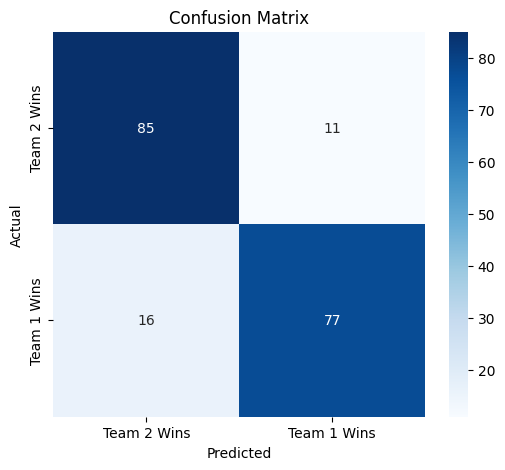

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


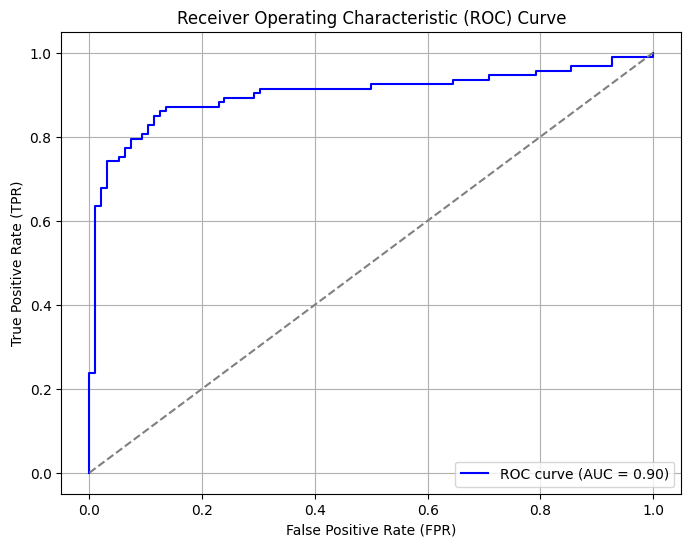

In [25]:
y_pred = (best_model.predict(X_test) > 0.5).astype("int32")

# Evaluate the model
print(f"Model Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Team 2 Wins', 'Team 1 Wins'],
            yticklabels=['Team 2 Wins', 'Team 1 Wins'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Get the predicted probabilities for the positive class (Team 1 Wins)
y_prob = best_model.predict(X_test)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (no discrimination)
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [26]:
from sklearn.model_selection import KFold

In [27]:
num_folds = 5

In [28]:
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)  # Set random_state for reproducibility

In [36]:
nba_series = pd.read_csv("TEAM_MATCHUP_DATA_FINAL.csv")
nba_series['SEASON'] = nba_series['SEASON'].astype(int)
train_data_gen = nba_series[nba_series['SEASON'] < 2005]
test_data_gen = nba_series[nba_series['SEASON'] == 2005]
columns_to_keep = ['SERIES_ID', 'SEASON', 'TEAM_1', 'TEAM_2', 'SERIES_WINNER']
train_data_preserved = train_data_gen[columns_to_keep]
test_data_preserved = test_data_gen[columns_to_keep]
nba_series = nba_series.drop(columns=['SERIES_ID', 'SEASON', 'SEASON_ID', 'TEAM_1_ID', 'TEAM_2_ID'])
train_data_gen = train_data_gen.drop(columns=['SERIES_ID', 'SEASON', 'SEASON_ID', 'TEAM_1_ID', 'TEAM_2_ID'])
test_data_gen = test_data_gen.drop(columns=['SERIES_ID', 'SEASON', 'SEASON_ID', 'TEAM_1_ID', 'TEAM_2_ID'])
nba_series['TEAM_1_W'] = (nba_series['SERIES_WINNER'] == nba_series['TEAM_1']).astype(int)
nba_series = nba_series.drop(columns=['TEAM_1', 'TEAM_2', 'SERIES_WINNER'])
train_data_gen['TEAM_1_W'] = (train_data_gen['SERIES_WINNER'] == train_data_gen['TEAM_1']).astype(int)
train_data_gen = train_data_gen.drop(columns=['TEAM_1', 'TEAM_2', 'SERIES_WINNER'])
test_data_gen['TEAM_1_W'] = (test_data_gen['SERIES_WINNER'] == test_data_gen['TEAM_1']).astype(int)
test_data_gen = test_data_gen.drop(columns=['TEAM_1', 'TEAM_2', 'SERIES_WINNER'])
X = nba_series.drop(columns=['TEAM_1_W'])
y = nba_series['TEAM_1_W']
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)
class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=y_resampled)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation='relu', input_dim=X_train.shape[1]),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def model_builder(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(units=hp.Int('units', min_value=32, max_value=512, step=32),
                                    activation='relu', input_dim=X_train.shape[1]))
    model.add(tf.keras.layers.Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

tuner = kt.Hyperband(model_builder, objective='val_accuracy', max_epochs=10, factor=3, directory='my_dir', project_name='intro_to_kt')
tuner.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test))
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

original_accuracies = []
tuned_accuracies = []

for fold, (train_indices, val_indices) in enumerate(kfold.split(X_train)):
    print(f"Fold {fold + 1}/{num_folds}")
    X_train_fold, X_val_fold = X_train[train_indices], X_train[val_indices]
    # Use .iloc to access data by position instead of label
    y_train_fold, y_val_fold = y_train.iloc[train_indices], y_train.iloc[val_indices]

    original_model = create_model()
    original_model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=32, validation_data=(X_val_fold, y_val_fold),
                        class_weight=class_weight_dict, callbacks=[early_stopping])
    _, original_accuracy = original_model.evaluate(X_val_fold, y_val_fold, verbose=0)
    original_accuracies.append(original_accuracy)

    tuned_model = tuner.hypermodel.build(best_hps)
    tuned_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_hps.get('learning_rate')),
                        loss='binary_crossentropy',
                        metrics=['accuracy'])
    tuned_model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=32, validation_data=(X_val_fold, y_val_fold),
                    class_weight=class_weight_dict, callbacks=[early_stopping])
    _, tuned_accuracy = tuned_model.evaluate(X_val_fold, y_val_fold, verbose=0)
    tuned_accuracies.append(tuned_accuracy)

avg_original_accuracy = np.mean(original_accuracies)
avg_tuned_accuracy = np.mean(tuned_accuracies)

print(f"Average Original Model Accuracy: {avg_original_accuracy * 100:.2f}%")
print(f"Average Tuned Model Accuracy: {avg_tuned_accuracy * 100:.2f}%")

if avg_tuned_accuracy > avg_original_accuracy:
    print("Hyperparameter tuning improved the model's accuracy.")
else:
    print("Hyperparameter tuning did not improve the model's accuracy.")

Reloading Tuner from my_dir/intro_to_kt/tuner0.json
Fold 1/5
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5395 - loss: 0.7400 - val_accuracy: 0.5114 - val_loss: 0.7159
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5785 - loss: 0.6675 - val_accuracy: 0.6591 - val_loss: 0.6262
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6320 - loss: 0.6250 - val_accuracy: 0.8068 - val_loss: 0.5450
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7985 - loss: 0.5241 - val_accuracy: 0.7955 - val_loss: 0.4563
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7781 - loss: 0.4713 - val_accuracy: 0.8295 - val_loss: 0.3791
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8351 - loss: 0.3873 - val_accuracy: 0.8409 - val_loss: 0.3956
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8044 - loss: 0.4116 - val_accuracy: 0.8295 - val_loss: 0.3728
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8275 - loss: 0.3814 - val_accuracy: 0.8636 - val_loss: 0.3

In [29]:
def create_model():  # Your original model creation function
    model = tf.keras.Sequential([
        # ... (Your model layers) ...
    tf.keras.layers.Dense(256, activation='relu', input_dim=X_train.shape[1]),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


def model_builder(hp):  # Your Keras Tuner model_builder function
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Dense(units=hp.Int('units', min_value=32, max_value=512, step=32),
                                    activation='relu', input_dim=X_train.shape[1]))
    model.add(tf.keras.layers.Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    # Define the optimizer with tunable learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        # ... (Your model layers with hyperparameters) ...

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


# ... (Rest of your code for data preparation, SMOTE, etc.) ...

# Create Keras Tuner object
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

# Perform k-fold cross-validation
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

original_accuracies = []
tuned_accuracies = []

for fold, (train_indices, val_indices) in enumerate(kfold.split(X_train)):
    print(f"Fold {fold + 1}/{num_folds}")
    X_train_fold, X_val_fold = X_train[train_indices], X_train[val_indices]
    # Use .iloc to access data by position instead of label
    y_train_fold, y_val_fold = y_train.iloc[train_indices], y_train.iloc[val_indices]

    # Train and evaluate the original model
    original_model = create_model()
    original_model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=32, validation_data=(X_val_fold, y_val_fold),
                        class_weight=class_weight_dict, callbacks=[early_stopping])
    _, original_accuracy = original_model.evaluate(X_val_fold, y_val_fold, verbose=0)
    original_accuracies.append(original_accuracy)

    # Train and evaluate the tuned model (using Keras Tuner)
    tuner.search(X_train_fold, y_train_fold, epochs=50, validation_data=(X_val_fold, y_val_fold),
                class_weight=class_weight_dict, callbacks=[early_stopping])
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    tuned_model = tuner.hypermodel.build(best_hps)
    tuned_model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=32, validation_data=(X_val_fold, y_val_fold),
                    class_weight=class_weight_dict, callbacks=[early_stopping])
    _, tuned_accuracy = tuned_model.evaluate(X_val_fold, y_val_fold, verbose=0)
    tuned_accuracies.append(tuned_accuracy)

# Calculate and print average accuracies
avg_original_accuracy = np.mean(original_accuracies)
avg_tuned_accuracy = np.mean(tuned_accuracies)

print(f"Average Original Model Accuracy: {avg_original_accuracy * 100:.2f}%")
print(f"Average Tuned Model Accuracy: {avg_tuned_accuracy * 100:.2f}%")



Reloading Tuner from my_dir/intro_to_kt/tuner0.json
Fold 1/5
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.5164 - loss: 0.7280 - val_accuracy: 0.5795 - val_loss: 0.6636
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6177 - loss: 0.6504 - val_accuracy: 0.6591 - val_loss: 0.6052
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6903 - loss: 0.5871 - val_accuracy: 0.7727 - val_loss: 0.5128
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7883 - loss: 0.4985 - val_accuracy: 0.8182 - val_loss: 0.4338
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8218 - loss: 0.4432 - val_accuracy: 0.7955 - val_loss: 0.4278
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8344 - loss: 0.3896 - val_accuracy: 0.8295 - val_loss: 0.3849
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9027 - loss: 0.2898 - val_accuracy: 0.8409 - val_loss: 0.3720
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8790 - loss: 0.2827 - val_accuracy: 0.8182 - val_loss: 0.

In [30]:
import pandas as pd
nba_series = pd.read_csv("TEAM_MATCHUP_DATA_FINAL.csv") # replace with your path
nba_series['SEASON'] = nba_series['SEASON'].astype(int)


# Trained on data from 1997-1999 and tested on 2000 data
train_data_gen = nba_series[nba_series['SEASON'] < 2024]
test_data_gen = nba_series[nba_series['SEASON'] == 2005]
data_2024_gen = nba_series[nba_series['SEASON'] == 2024]  # Filter data for 2024

columns_to_keep = ['SERIES_ID', 'SEASON', 'TEAM_1', 'TEAM_2', 'SERIES_WINNER']
train_data_preserved = train_data_gen[columns_to_keep]
test_data_preserved = test_data_gen[columns_to_keep]
data_2024_preserved = data_2024_gen[columns_to_keep]

nba_series = nba_series.drop(columns = ['SERIES_ID', 'SEASON', 'SEASON_ID', 'TEAM_1_ID', 'TEAM_2_ID'])
train_data_gen = train_data_gen.drop(columns = ['SERIES_ID', 'SEASON', 'SEASON_ID', 'TEAM_1_ID', 'TEAM_2_ID'])
test_data_gen = test_data_gen.drop(columns = ['SERIES_ID', 'SEASON', 'SEASON_ID', 'TEAM_1_ID', 'TEAM_2_ID'])
data_2024_gen = data_2024_gen.drop(columns=['SERIES_ID', 'SEASON', 'SEASON_ID', 'TEAM_1_ID', 'TEAM_2_ID']) # Drop for 2024

nba_series['TEAM_1_W'] = (nba_series['SERIES_WINNER'] == nba_series['TEAM_1']).astype(int)
nba_series = nba_series.drop(columns = ['TEAM_1', 'TEAM_2', 'SERIES_WINNER'])

train_data_gen['TEAM_1_W'] = (train_data_gen['SERIES_WINNER'] == train_data_gen['TEAM_1']).astype(int)
train_data_gen = train_data_gen.drop(columns = ['TEAM_1', 'TEAM_2', 'SERIES_WINNER'])

test_data_gen['TEAM_1_W'] = (test_data_gen['SERIES_WINNER'] == test_data_gen['TEAM_1']).astype(int)
test_data_gen = test_data_gen.drop(columns = ['TEAM_1', 'TEAM_2', 'SERIES_WINNER'])

data_2024_gen['TEAM_1_W'] = (data_2024_gen['SERIES_WINNER'] == data_2024_gen['TEAM_1']).astype(int) # Create target for 2024
data_2024_gen = data_2024_gen.drop(columns=['TEAM_1', 'TEAM_2', 'SERIES_WINNER']) # Drop unnecessary columns for 2024


X = nba_series.drop(columns=['TEAM_1_W'])
y = nba_series['TEAM_1_W']



# Testing on 2024 data:
X_2024 = data_2024_gen.drop(columns=['TEAM_1_W'])
y_2024 = data_2024_gen['TEAM_1_W']

X_2024_scaled = scaler.transform(X_2024)
y_pred_2024 = (best_model.predict(X_2024_scaled) > 0.5).astype("int32")  # Make predictions

# Evaluate performance
print(f"Accuracy on 2024 data: {accuracy_score(y_2024, y_pred_2024) * 100:.2f}%")
print("\nClassification Report for 2024 data:")
print(classification_report(y_2024, y_pred_2024))


data_2024_preserved['PRED_WINNER'] = y_pred_2024
print(data_2024_preserved) #

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Accuracy on 2024 data: 100.00%

Classification Report for 2024 data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         9

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15

        SERIES_ID  SEASON                  TEAM_1                  TEAM_2  \
405  2024_BOS_CLE    2024          Boston Celtics     Cleveland Cavaliers   
406  2024_BOS_DAL    2024          Boston Celtics        Dallas Mavericks   
407  2024_BOS_IND    2024          Boston Celtics          Indiana Pacers   
408  2024_BOS_MIA    2024          Boston Celtics              Miami Heat   
409  2024_CLE_ORL    2024     Cleveland Cavaliers           Orlando Magic   
410  2024_DAL_LAC    2024             LA Clippers        Dallas Mavericks   
411  2024_DAL_MIN    2024  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Accuracy on 2022 data: 100.00%

Classification Report for 2022 data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00        10

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15

        SERIES_ID  SEASON              TEAM_1                  TEAM_2  \
360  2021_ATL_MIL    2021     Milwaukee Bucks           Atlanta Hawks   
361  2021_ATL_NYK    2021     New York Knicks           Atlanta Hawks   
362  2021_ATL_PHI    2021  Philadelphia 76ers           Atlanta Hawks   
363  2021_BKN_BOS    2021       Brooklyn Nets          Boston Celtics   
364  2021_BKN_MIL    2021       Brooklyn Nets         Milwaukee Bucks   
365  2021_DAL_LAC    2021         LA Clippers        Dallas Mavericks   
366  2021_DEN_PHX    2021        Phoenix Suns          

In [29]:
def model_builder(hp):
    model = tf.keras.Sequential()

    hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
    model.add(tf.keras.layers.Dense(units=hp_units1, activation='relu', input_dim=X_train.shape[1]))
    model.add(tf.keras.layers.Dense(units=hp.Int('units1', min_value=32, max_value=512, step=32),
                                    activation='relu', input_dim=X_train.shape[1],
                                    kernel_regularizer=tf.keras.regularizers.l2(hp.Choice('l2_reg', values=[0.1, 0.01, 0.001]))))
    model.add(BatchNormalization())

    hp_dropout = hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)
    model.add(tf.keras.layers.Dropout(rate=hp_dropout))


    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='nba_tuning')

tuner.search(X_train, y_train, epochs=50,
            validation_data=(X_test, y_test),
            callbacks=[early_stopping],
            class_weight=class_weight_dict)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

best_model = tuner.hypermodel.build(best_hps)

history = best_model.fit(X_train, y_train, epochs=50, batch_size=32,
                         validation_data=(X_test, y_test),
                         callbacks=[early_stopping],
                         class_weight=class_weight_dict)


Trial 30 Complete [00h 00m 06s]
val_accuracy: 0.8465608358383179

Best val_accuracy So Far: 0.8835979104042053
Total elapsed time: 00h 02m 20s
Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.5223 - loss: 2.4978 - val_accuracy: 0.6508 - val_loss: 2.1071
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8107 - loss: 1.8840 - val_accuracy: 0.7354 - val_loss: 1.9400
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8985 - loss: 1.6477 - val_accuracy: 0.7831 - val_loss: 1.8045
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9627 - loss: 1.4364 - val_accuracy: 0.8201 - val_loss: 1.6693
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9793 - loss: 1.3037 - val_accuracy: 0.8095 - val_loss: 1.5543
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9903 - loss: 1.1707 - val_accuracy: 0.7989 - val_loss: 1.4734
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9975 - loss: 1.0648 - val_accuracy:

# New Section

In [56]:
def augment_data(X, noise_factor=0.2):  # Adjust noise_factor as needed
    noise = np.random.normal(0, noise_factor, X.shape)  # Gaussian noise
    X_augmented = X + noise
    return X_augmented

# Apply data augmentation before training
X_train_augmented = augment_data(X_train)
# Replace ... with actual arguments like batch_size, epochs, etc.
history = best_model.fit(X_train_augmented, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),
                         class_weight=class_weight_dict, callbacks=[early_stopping]) # Train with augmented data

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9678 - loss: 0.2267 - val_accuracy: 0.7989 - val_loss: 0.6277
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9350 - loss: 0.3045 - val_accuracy: 0.7989 - val_loss: 0.6639
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9625 - loss: 0.2985 - val_accuracy: 0.8466 - val_loss: 0.5696
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9952 - loss: 0.2293 - val_accuracy: 0.8307 - val_loss: 0.6253
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9936 - loss: 0.1863 - val_accuracy: 0.7989 - val_loss: 0.5694
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9912 - loss: 0.1536 - val_accuracy: 0.7725 - val_loss: 0.6659
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9576 - loss: 0.2371 - val_accuracy: 0.7884 - val_loss: 0.6203
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9918 - loss: 0.1834 - val_accuracy: 0.8360 - v

In [30]:
# Handle class imbalance using SMOTE
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Standardize the features
scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)

In [31]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

# Define the number of folds
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Store results
fold_accuracies = []
fold_auc_scores = []

for train_idx, val_idx in skf.split(X_resampled, y_resampled):
    # Split data into train and validation sets
    X_train, X_val = X_resampled[train_idx], X_resampled[val_idx]
    y_train, y_val = y_resampled[train_idx], y_resampled[val_idx]

    # Build the model inside the loop
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation='relu', input_dim=X_train.shape[1], kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val),
              class_weight=class_weight_dict, callbacks=[early_stopping], verbose=0)

    # Evaluate the model
    y_pred = (model.predict(X_val) > 0.5).astype("int32")
    y_prob = model.predict(X_val)

    # Compute accuracy
    accuracy = accuracy_score(y_val, y_pred)
    fold_accuracies.append(accuracy)

    # Compute AUC
    fpr, tpr, _ = roc_curve(y_val, y_prob)
    roc_auc = auc(fpr, tpr)
    fold_auc_scores.append(roc_auc)

    print(f"Fold Accuracy: {accuracy * 100:.2f}%, AUC: {roc_auc:.2f}")

# Compute the average performance
print(f"\nAverage Accuracy: {np.mean(fold_accuracies) * 100:.2f}% ± {np.std(fold_accuracies) * 100:.2f}%")
print(f"Average AUC: {np.mean(fold_auc_scores):.2f} ± {np.std(fold_auc_scores):.2f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Fold Accuracy: 84.13%, AUC: 0.91


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Fold Accuracy: 86.51%, AUC: 0.95


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Fold Accuracy: 89.68%, AUC: 0.95


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Fold Accuracy: 87.20%, AUC: 0.89


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Fold Accuracy: 85.60%, AUC: 0.93

Average Accuracy: 86.62% ± 1.84%
Average AUC: 0.93 ± 0.02


In [32]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

# Define the number of folds
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Store results
fold_accuracies = []
fold_auc_scores = []

for train_idx, val_idx in skf.split(X_resampled, y_resampled):
    # Split data into train and validation sets
    X_train, X_val = X_resampled[train_idx], X_resampled[val_idx]
    y_train, y_val = y_resampled[train_idx], y_resampled[val_idx]

    # Build the model inside the loop


    # Compile the model
    best_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    best_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val),
              class_weight=class_weight_dict, callbacks=[early_stopping], verbose=0)

    # Evaluate the model
    y_pred = (best_model.predict(X_val) > 0.5).astype("int32")
    y_prob = best_model.predict(X_val)

    # Compute accuracy
    accuracy = accuracy_score(y_val, y_pred)
    fold_accuracies.append(accuracy)

    # Compute AUC
    fpr, tpr, _ = roc_curve(y_val, y_prob)
    roc_auc = auc(fpr, tpr)
    fold_auc_scores.append(roc_auc)

    print(f"Fold Accuracy: {accuracy * 100:.2f}%, AUC: {roc_auc:.2f}")

# Compute the average performance
print(f"\nAverage Accuracy: {np.mean(fold_accuracies) * 100:.2f}% ± {np.std(fold_accuracies) * 100:.2f}%")
print(f"Average AUC: {np.mean(fold_auc_scores):.2f} ± {np.std(fold_auc_scores):.2f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Fold Accuracy: 95.24%, AUC: 0.97
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Fold Accuracy: 100.00%, AUC: 1.00
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Fold Accuracy: 100.00%, AUC: 1.00
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Fold Accuracy: 98.40%, AUC: 1.00
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Fold Accuracy: 100.00%, AUC: 1.00

Average Accuracy: 98.73% ± 1.85%
Average AUC: 0.99 ± 0.01


In [37]:
best_learning_rate = best_hps.get('learning_rate')
print(f"Learning Rate for the best model: {best_learning_rate}")

Learning Rate for the best model: 0.001


In [35]:
best_model = tuner.hypermodel.build(best_hps)

# 1. Get the model's configuration (architecture and hyperparameters):
model_config = best_model.get_config()
print("Model Configuration:", model_config)

# 2. Get the weights and biases of the model's layers:
for layer in best_model.layers:
    layer_weights = layer.get_weights()  # Get all weights for the layer
    print(f"Layer: {layer.name}")

    # Check if layer has weights and biases
    if layer_weights:
        print("  Weights:", layer_weights[0]) # Print weights if they exist
        if len(layer_weights) > 1:
            print("  Biases:", layer_weights[1])  # Print biases if they exist
    else:
        print("  No trainable weights")


# 3. Access specific hyperparameters from best_hps:
learning_rate = best_hps.get('learning_rate')
units1 = best_hps.get('units1')
dropout = best_hps.get('dropout')
l2_reg = best_hps.get('l2_reg')  # If you used L2 regularization
print(f"Learning Rate: {learning_rate}")
print(f"Units in First Layer: {units1}")
print(f"Dropout Rate: {dropout}")
print(f"L2 Regularization: {l2_reg}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model Configuration: {'name': 'sequential_9', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': (None, 166), 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_9'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_37', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'units': 160, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': Non

In [38]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]  # Extract best hyperparameters

print("Best Hyperparameters:")
for key, value in best_hps.values.items():
    print(f"{key}: {value}")


best_model = tuner.hypermodel.build(best_hps)
best_model.summary()  # View model architecture

Best Hyperparameters:
units: 352
dropout: 0.1
learning_rate: 0.001
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0020


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_77 (Dense)                     │ (None, 352)                 │          58,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 352)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_78 (Dense)                     │ (None, 1)                   │             353 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 59,137 (231.00 KB)

 Trainable params: 59,137 (231.00 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
for layer in best_model.layers:
    layer_weights = layer.get_weights()  # Get all weights for the layer
    print(f"Layer: {layer.name}, Type: {type(layer).__name__}")

    if layer_weights:
        # Dense or similar layers
        if len(layer_weights) == 2:
            print("  Weights:", layer_weights[0]) # Print weights if they exist
            print("  Biases:", layer_weights[1])  # Print biases if they exist
        # Batch Normalization layers
        elif len(layer_weights) == 4:
            print("  Gamma:", layer_weights[0])
            print("  Beta:", layer_weights[1])
            print("  Moving Mean:", layer_weights[2])
            print("  Moving Variance:", layer_weights[3])
        # Other layer types (add more as needed)
        else:
            print("  Weights/Parameters:", layer_weights)
    else:
        print("  No trainable weights")

Layer: dense_77, Type: Dense
  Weights: [[ 0.0529361   0.01196633 -0.07643545 ... -0.04229753 -0.07455
   0.00911849]
 [ 0.08630642 -0.008657    0.08522842 ... -0.00447258  0.10609078
  -0.0096845 ]
 [-0.1008182  -0.04595193  0.07929253 ...  0.0028417   0.04446886
  -0.02900601]
 ...
 [-0.05847307  0.0664373  -0.0773503  ...  0.02680177 -0.04836573
   0.08736417]
 [ 0.09903655 -0.07376957  0.07487344 ... -0.0747771   0.09026549
  -0.0187187 ]
 [ 0.10123695 -0.00566332 -0.06582873 ... -0.02820869 -0.02621152
   0.02452948]]
  Biases: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0

In [46]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]  # Extract best hyperparameters

best_params = {
    'units1': best_hps.get('units'),  # Change 'units1' to 'units'
    'dropout': best_hps.get('dropout'),
    'learning_rate': best_hps.get('learning_rate'),
    #'l2_reg': best_hps.get('l2_reg'),
    'activation_1': 'relu',  # Assuming your first layer's activation
    # Add other parameters you want to include
    'optimizer': 'adam',
    'batch_size': 32,
    #'epochs': best_hps.get('epochs') #Assuming you want to use the best epoch

}

print("Best Hyperparameters:")
for key, value in best_hps.values.items():
    print(f"{key}: {value}")


best_model = tuner.hypermodel.build(best_hps)
best_model.summary()  # View model architecture

#print("\nBest Parameters Dictionary:", best_params)
print(best_params)

Best Hyperparameters:
units: 352
dropout: 0.1
learning_rate: 0.001
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0020


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_83 (Dense)                     │ (None, 352)                 │          58,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 352)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_84 (Dense)                     │ (None, 1)                   │             353 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 59,137 (231.00 KB)

 Trainable params: 59,137 (231.00 KB)

 Non-trainable params: 0 (0.00 B)

{'units1': 352, 'dropout': 0.1, 'learning_rate': 0.001, 'activation_1': 'relu', 'optimizer': 'adam', 'batch_size': 32}
